<a href="https://colab.research.google.com/github/xAn-x/Language-Modelling-Zero-to-One/blob/master/04_Transformers_for_Language_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-11-07 04:08:01--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.02s   

2024-11-07 04:08:01 (50.1 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [ ]:
with open('input.txt','r',encoding='utf-8') as f:
  text=f.read()

In [ ]:
print(text[:300])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us


In [ ]:
vocab=sorted(list(set(text)))
vocab_size=len(vocab)

print(f"vocab_size: {vocab_size}")
print(f"vocab: {vocab}")

vocab_size: 65
vocab: ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [ ]:
stoi={ch:i for i,ch in enumerate(vocab)}
itos={i:ch for i,ch in enumerate(vocab)}

def encode(s):
  return [stoi[ch] for ch in s]

def decode(l):
  return ''.join([itos[i] for i in l])

In [ ]:
print(encode("hello, there"))
print(decode(encode("hello, there")))

[46, 43, 50, 50, 53, 6, 1, 58, 46, 43, 56, 43]
hello, there


In [ ]:
data=torch.tensor(encode(text),dtype=torch.long)
print(data.shape,data.dtype)
print(data[:100])

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])


In [ ]:
train_size=int(0.9*len(data))
train_data=data[:train_size]
val_data=data[train_size:]

print(f"train_size: {train_size}")
print(f"val_size: {len(val_data)}")

train_size: 1003854
val_size: 111540


In [ ]:
def get_batch(batch_size,block_size,split="train"):
  if split=="train":
    data=train_data
  else:
    data=val_data

  n=len(data)
  ix=torch.randint(n-block_size-1,(batch_size,))
  x=torch.stack([data[i:i+block_size] for i in ix])
  y=torch.stack([data[i+1:i+block_size+1] for i in ix])

  return x,y

In [ ]:
batch_size,block_size=8,64
x,y=get_batch(batch_size,block_size)

print(f"x.shape: {x.shape}")
print(f"y.shape: {y.shape}")
print('\n',".*."*15,end='\n\n')
print(f"x:{x}\n")
print(f"y:{y}\n")

x.shape: torch.Size([8, 64])
y.shape: torch.Size([8, 64])

 .*..*..*..*..*..*..*..*..*..*..*..*..*..*..*.

x:tensor([[58, 46, 43,  1, 43, 39, 56,  1, 61, 47, 58, 46,  1, 39,  0, 50, 53, 60,
         43,  7, 57, 53, 52, 45, 11,  1, 58, 46, 43,  1, 60, 43, 56, 63,  1, 54,
         47, 52,  1, 53, 44,  1, 46, 47, 57,  1, 46, 43, 39, 56, 58,  1, 41, 50,
         43, 44, 58,  1, 61, 47, 58, 46,  1, 58],
        [47, 57,  1, 63, 53, 59, 56,  1, 44, 53, 56, 51, 43, 56,  1, 54, 56, 53,
         51, 47, 57, 43,  8,  0,  0, 25, 13, 30, 15, 21, 33, 31, 10,  0, 31, 47,
         56,  6,  1, 47, 58,  1, 47, 57, 11,  0, 13, 52, 42,  1, 21,  1, 39, 51,
          1, 41, 53, 52, 57, 58, 39, 52, 58,  8],
        [ 1, 58, 39, 49, 43,  1, 58, 53,  1, 63, 53, 59, 56,  1, 56, 53, 63, 39,
         50,  1, 57, 43, 50, 44,  0, 32, 46, 47, 57,  1, 54, 56, 53, 44, 44, 43,
         56,  5, 42,  1, 40, 43, 52, 43, 44, 47, 58,  1, 53, 44,  1, 42, 47, 45,
         52, 47, 58, 63, 11,  0, 21, 44,  1, 52],
        [ 1,

In [ ]:
decode(x[1].tolist())

'is your former promise.\n\nMARCIUS:\nSir, it is;\nAnd I am constant.'

## `Transformer-Model-Architecture:`

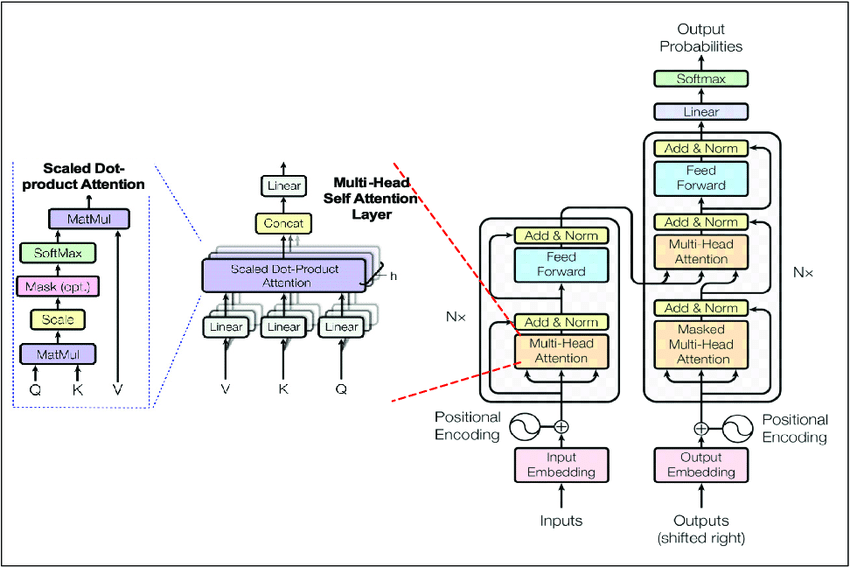

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ContextualEmbeddings(nn.Module):
    def __init__(self, vocab_size: int, context_len: int, embedding_dim: int):
        super().__init__()
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.positional_embeddings = nn.Embedding(context_len, embedding_dim)
        self.register_buffer("positions", torch.arange(context_len).unsqueeze(0))  # Shape (1, context_len)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x.shape: (B, T)
        pos = self.positions[:, :x.size(1)]  # Adjust positions to match input size
        return self.word_embeddings(x) + self.positional_embeddings(pos)

def scaled_dot_product_attention(q, k, v, head_size, mask=None):
    # Scaled dot-product attention with optional masking
    weights = q @ k.transpose(-2, -1) / head_size**0.5
    if mask is not None:
        weights = weights.masked_fill(mask == 0, float('-inf'))
    weights = F.softmax(weights, dim=-1)
    return weights @ v

class AttentionHead(nn.Module):
    def __init__(self, embedding_dim: int, head_size: int):
        super().__init__()
        self.query = nn.Linear(embedding_dim, head_size)
        self.key = nn.Linear(embedding_dim, head_size)
        self.value = nn.Linear(embedding_dim, head_size)
        self.head_size = head_size

    def forward(self, x: torch.Tensor, mask: torch.Tensor = None) -> torch.Tensor:
        q = self.query(x)
        k = self.key(x)
        v = self.value(x)
        return scaled_dot_product_attention(q, k, v, self.head_size, mask)

class MultiHeadAttention(nn.Module):
    def __init__(self, embedding_dim: int, n_heads: int):
        super().__init__()
        assert embedding_dim % n_heads == 0, f"embedding_dim ({embedding_dim}) not divisible by n_heads ({n_heads})"
        head_size = embedding_dim // n_heads
        self.attention_heads = nn.ModuleList([AttentionHead(embedding_dim, head_size) for _ in range(n_heads)])
        self.proj = nn.Linear(embedding_dim, embedding_dim)

    def forward(self, x: torch.Tensor, mask: torch.Tensor = None) -> torch.Tensor:
        attention_outputs = [head(x, mask) for head in self.attention_heads]
        return self.proj(torch.cat(attention_outputs, dim=-1))

class ProjectionLayer(nn.Module):
    def __init__(self, in_features: int, projection_fact: int = 4):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_features, in_features * projection_fact),
            nn.ReLU(),
            nn.Linear(in_features * projection_fact, in_features),
            nn.Dropout(0.3),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.fc(x)

class DecoderBlock(nn.Module):
    def __init__(self, embedding_dim: int, n_heads: int, projection_fact: int = 4):
        super().__init__()
        self.ln1 = nn.LayerNorm(embedding_dim)
        self.multi_head_attention = MultiHeadAttention(embedding_dim, n_heads)
        self.ln2 = nn.LayerNorm(embedding_dim)
        self.proj = ProjectionLayer(embedding_dim, projection_fact)

    def forward(self, x: torch.Tensor, mask: torch.Tensor = None) -> torch.Tensor:
        x = x + self.multi_head_attention(self.ln1(x), mask)
        x = x + self.proj(self.ln2(x))
        return x

class Decoder(nn.Module):
    def __init__(self, embedding_dim: int, n_blocks: int, n_heads: int, projection_fact: int = 4):
        super().__init__()
        self.blocks = nn.ModuleList([DecoderBlock(embedding_dim, n_heads, projection_fact) for _ in range(n_blocks)])

    def forward(self, x: torch.Tensor, mask: torch.Tensor = None) -> torch.Tensor:
        for block in self.blocks:
            x = block(x, mask)
        return x

class Model(nn.Module):
    def __init__(self, vocab_size: int, block_size: int, n_embed: int, n_heads: int, n_layers: int, projection_factor: int = 4):
        super().__init__()
        self.embeddings = ContextualEmbeddings(vocab_size, block_size, n_embed)
        self.decoder = Decoder(n_embed, n_layers, n_heads, projection_factor)
        self.norm = nn.LayerNorm(n_embed)
        self.fc = nn.Linear(n_embed, vocab_size)
        self.register_buffer("mask", torch.tril(torch.ones(block_size, block_size)).unsqueeze(0).unsqueeze(0))  # Shape (1, 1, block_size, block_size)

    def forward(self, x: torch.Tensor, targets: torch.Tensor = None):
        x = self.embeddings(x)
        mask = self.mask[:, :, :x.size(1), :x.size(1)]
        x = self.decoder(x, mask)
        x = self.fc(self.norm(x))

        loss = None
        if targets is not None:
            x = x.view(-1, x.size(-1))
            targets = targets.view(-1)
            loss = F.cross_entropy(x, targets)
        return x, loss


In [ ]:
batch_size=128
block_size=256
n_embed=128
vocab_size=65
n_heads=8
n_layers=7
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model=Model(vocab_size,block_size,n_embed,n_heads,n_layers)

print(device)
model.to(device)

cuda


Model(
  (embeddings): ContextualEmbeddings(
    (word_embeddings): Embedding(65, 128)
    (positional_embeddings): Embedding(256, 128)
  )
  (decoder): Decoder(
    (blocks): ModuleList(
      (0-6): 7 x DecoderBlock(
        (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (multi_head_attention): MultiHeadAttention(
          (attention_heads): ModuleList(
            (0-7): 8 x AttentionHead(
              (query): Linear(in_features=128, out_features=16, bias=True)
              (key): Linear(in_features=128, out_features=16, bias=True)
              (value): Linear(in_features=128, out_features=16, bias=True)
            )
          )
          (proj): Linear(in_features=128, out_features=128, bias=True)
        )
        (ln2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (proj): ProjectionLayer(
          (fc): Sequential(
            (0): Linear(in_features=128, out_features=512, bias=True)
            (1): ReLU()
            (2): Linear(in_

In [ ]:
sum(p.numel() for p in model.parameters())

1437633

In [ ]:
# Dev-Test-Run
X,y=get_batch(batch_size,block_size)
X,y=X.to(device),y.to(device)


logits,loss=model(X,y)
logits.shape,loss

(torch.Size([32768, 65]),
 tensor(4.3487, device='cuda:0', grad_fn=<NllLossBackward0>))

In [ ]:
# Define the optimizer and the learning rate scheduler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
optimizer = torch.optim.AdamW(model.parameters(),2e-4)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=100, T_mult=2)

epochs=3000
eval_interval=10
log_every_kth_epoch=100
save_every_kth_epoch=1000

In [ ]:
from tqdm.notebook import tqdm


@torch.no_grad()
def evaluate(model, eval_interval):
    model.eval()
    for split in ["train", "val"]:
        losses = []
        for _ in tqdm(range(eval_interval),desc="Evaluating..."):
            x, y = get_batch(batch_size, block_size, split)
            x, y = x.to(device), y.to(device)
            logits, loss = model(x, y)
            losses.append(loss.item())
        losses = np.array(losses)
        print(f"{split}_loss: {losses.mean():.2f}")

def train():
    history = {"train_loss": [], "val_loss": []}
    best_val_loss = float("inf")
    patience = 20
    patience_counter = 0

    for epoch in tqdm(range(epochs),desc="Training...."):
        optimizer.zero_grad()
        model.train()

        X, y = get_batch(batch_size, block_size)
        X, y = X.to(device), y.to(device)
        logits, loss = model(X, y)

        loss.backward()
        optimizer.step()
        scheduler.step(epoch + (epoch / epochs))

        model.eval()
        with torch.no_grad():
            X, y = get_batch(batch_size, block_size, "valid")
            X, y = X.to(device), y.to(device)
            logits, val_loss = model(X, y)

        history["train_loss"].append(loss.item())
        history["val_loss"].append(val_loss.item())

        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            patience_counter = 0
            torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Saved Models/best-model.pth")
            # print(f"Epoch {epoch+1}: Model saved with val_loss: {best_val_loss:.4f}")

        if (epoch + 1) % log_every_kth_epoch == 0:
            print(f"EPOCH: {epoch+1}/{epochs}:\n")
            evaluate(model, eval_interval)
            print()

        if (epoch + 1) % save_every_kth_epoch == 0:
            print("Saving Model....")
            torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Saved Models/decoder-model.pth")
            print("Model Saved....\n")

    return history


In [ ]:
history=train()

Training....:   0%|          | 0/3000 [00:00<?, ?it/s]

EPOCH: 100/3000:



Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

train_loss: 2.92


Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.94

EPOCH: 200/3000:



Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

train_loss: 2.59


Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.60

EPOCH: 300/3000:



Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

train_loss: 2.57


Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.57

EPOCH: 400/3000:



Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

train_loss: 2.51


Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.51

EPOCH: 500/3000:



Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

train_loss: 2.47


Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.48

EPOCH: 600/3000:



Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

train_loss: 2.46


Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.47

EPOCH: 700/3000:



Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

train_loss: 2.46


Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.47

EPOCH: 800/3000:



Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

train_loss: 2.43


Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.44

EPOCH: 900/3000:



Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

train_loss: 2.38


Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.39

EPOCH: 1000/3000:



Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

train_loss: 2.32


Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.34

Saving Model....
Model Saved....

EPOCH: 1100/3000:



Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

train_loss: 2.28


Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.30

EPOCH: 1200/3000:



Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

train_loss: 2.25


Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.27

EPOCH: 1300/3000:



Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

train_loss: 2.24


Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.26

EPOCH: 1400/3000:



Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

train_loss: 2.23


Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.25

EPOCH: 1500/3000:



Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

train_loss: 2.22


Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.26

EPOCH: 1600/3000:



Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

train_loss: 2.18


Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.21

EPOCH: 1700/3000:



Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

train_loss: 2.13


Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.17

EPOCH: 1800/3000:



Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

train_loss: 2.09


Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.14

EPOCH: 1900/3000:



Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

train_loss: 2.05


Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.10

EPOCH: 2000/3000:



Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

train_loss: 2.01


Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.08

Saving Model....
Model Saved....

EPOCH: 2100/3000:



Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

train_loss: 1.97


Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.06

EPOCH: 2200/3000:



Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

train_loss: 1.95


Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.04

EPOCH: 2300/3000:



Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

train_loss: 1.93


Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.02

EPOCH: 2400/3000:



Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

train_loss: 1.91


Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.00

EPOCH: 2500/3000:



Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

train_loss: 1.89


Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 2.00

EPOCH: 2600/3000:



Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

train_loss: 1.88


Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.99

EPOCH: 2700/3000:



Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

train_loss: 1.88


Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.98

EPOCH: 2800/3000:



Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

train_loss: 1.88


Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.98

EPOCH: 2900/3000:



Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

train_loss: 1.87


Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.97

EPOCH: 3000/3000:



Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

train_loss: 1.87


Evaluating...:   0%|          | 0/10 [00:00<?, ?it/s]

val_loss: 1.97

Saving Model....
Model Saved....



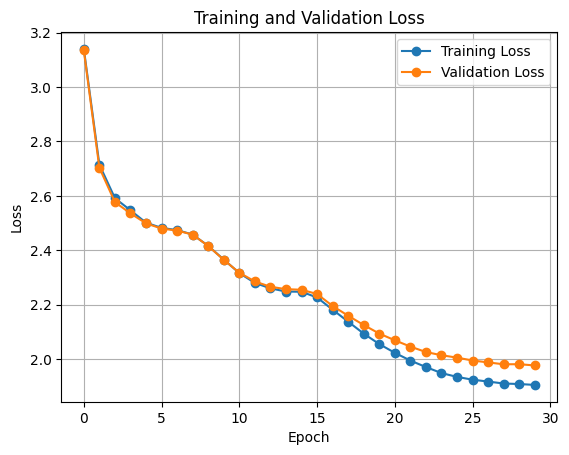

In [ ]:
def plot_loss(history):
    train_loss=torch.tensor(history["train_loss"]).view(-1,100).mean(-1)
    val_loss=torch.tensor(history["val_loss"]).view(-1,100).mean(-1)

    plt.plot(train_loss, label='Training Loss', marker='o')
    plt.plot(val_loss, label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(history)

In [ ]:
@torch.no_grad()
def generate(n_words=300):
    model.eval()
    idx = torch.randint(0, train_data.size(0), (1,))
    text = train_data[idx:idx+block_size].unsqueeze(0).to(device)
    lst = []

    for _ in range(n_words):
        logits,_=model(text)
        logits = logits[:, -1, -1]  # Get logits for the last token in the sequence (shape: (1, vocab_size))
        # print(logits.shape)
        probs = F.softmax(logits[0], dim=-1)  # Take the last token's logits
        # print(probs.shape)
        new_ix = torch.multinomial(probs, num_samples=1)
        # print(new_ix.shape)
        # break

        lst.append(new_ix.item())
        # Update the context, expanding up to block_size and then rolling
        if text.size(1) < block_size:
            text = torch.cat([text, new_ix.unsqueeze(0)], dim=1)
        else:
            text = torch.cat([text[:, 1:], new_ix.unsqueeze(0)], dim=1)

    return "".join(decode(lst))

In [ ]:
generated_text=generate(1000)
print(generated_text)

th hish lieve this my plather.

COLINCEND:
Were, not ladst and hach I wher man he Lork
Thould ose in theus of and so omur con love.

DOMNjEN:
I on shey, chach gie ganfomburst of him.
Which you ladgess! I shir in dimede, sue thath,
Not by ucurch, aftblly, with, as clearl me you,-ay this! lord,
Had ther you he must me, binght antry,
Buckent be him the this the cavingest ang.

WIF RICH:
My sond, no busteer, the dingnts thy gauns
voy bun Brenntf dimbtthourck;
You I plove to wrenked it this le the theer
Shat sory and thishe grancetong it gooden.

Firlr:
And, I the the mirble thinght with he fatught
And is makiod.

GELONCER:
Ankey, of lumettie herllver no with oulds of,
Thou come meorffene him that unmy time;
andlleinten tuing hous I's avirin!
ToNur:
Morst Dery natteroould swilly will with is beretlesh:
And mutht mee werssen hould beir, with tove
wit thir lacke ovarl 'Thou, and sI ony and aunch's I sull
For lom shis worcaring in of ralombntery;
And Murepow's henry mother wore fat loak'd
To i

In [ ]:
# torch.save(model.state_dict(),"/content/drive/MyDrive/Colab Notebooks/Saved Models/decoder-model.pth")